In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
import numpy as np

In [2]:
# Code to display progress bar
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# Check if GPU avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [4]:
from torch.utils.data import DataLoader

# Initialize dataset
# Using Cifar100
DATA_PATH = "./data"

s_min = 256
s_max = 512
batch_size = 8

train_transform = transforms.Compose([
    transforms.Resize(s_max),
    transforms.RandomResizedCrop(224, scale=(s_min/s_max, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # TODO: add image RGB augmentation in https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
    
])
test_transform = transforms.Compose([])

train_dataset = datasets.CIFAR100(f"{DATA_PATH}/train", train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR100(f"{DATA_PATH}/test", train=False, transform=test_transform, download=True)

# Train and validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


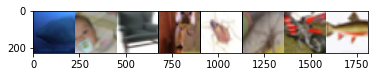

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5  # Un-normalize your image here
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
from vggnet import VGGNet

vggnet = VGGNet("vgg16").to(device)
optim = torch.optim.SGD(vggnet.parameters(), lr=10e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5)
criterion = torch.nn.CrossEntropyLoss()

D:\Coding\Machine Learning\Deep Learning\ImageNet Evolution\VGG\vggnet.py:90: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


In [ ]:
vggnet

VGGNet(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), paddi

In [ ]:
import os.path

MODEL_PATH = "models/vgg.pth"
if os.path.isfile(MODEL_PATH):
    print("Loading save model")
    if torch.cuda.is_available():
        vggnet.load_state_dict(torch.load(MODEL_PATH))
    else:
        vggnet.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device('cpu')))
    print("Model loaded successfully")
else:
    print("Model not found")

Model not found


In [ ]:
# Training code

import time

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} ", end="")
#     if epoch % 5 == 0:
#         torch.save(vggnet.state_dict(), MODEL_PATH)
    
    running_loss = 0.0
    t0 = time.time()
    vggnet.train()
    for data in log_progress((train_loader)):
        # Switch to training mode
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = vggnet(inputs)
        
        # Backwards propagation
        loss = criterion(outputs, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        running_loss += loss.item()
    
    
    val_loss = 0.0
    with torch.no_grad():
        for i,data in enumerate(val_loader):
            # Switch to eval mode
            vggnet.eval()

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = vggnet(inputs)

            # Backwards propagation
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        
        prev_val_loss = val_loss
        t1 = time.time()
        time_total = t1-t0
        avg_val_loss = val_loss / (val_size/batch_size)
        scheduler.step(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss}, Time Taken: {time_total} ")

        
print("Training concluded")


Epoch 1 

Validation Loss: 4.636568143081665, Time Taken: 1920.4625041484833 
Epoch 2 

In [ ]:
#TODO: Test model